In [1]:
%config Completion.use_jedi = False
%reload_ext autoreload
%autoreload 2

import sys
import os
sys.path.append("../")

In [2]:
from pprint import pprint

import mlflow
from torchvision import transforms
from torch.utils.data import DataLoader
from torchmetrics.classification import MultilabelConfusionMatrix

from src.custom_datasets import MultiLabelImageFolder
from src.model import MultiLabelClassifier

# 1. Model Evaluation

In [3]:
checkpoint = "checkpoints/Experiment_2-Resnet18-pretrained_unfrozen-weights/epoch=47-step=2016.ckpt"
model = MultiLabelClassifier.load_from_checkpoint(checkpoint)

Using cache found in /Users/ryoshibata/.cache/torch/hub/pytorch_vision_main


In [4]:
local_uri = "/Users/ryoshibata/Coding_projects/MLFlow_runs/"
run_id = '6bbf9a7f456d40d9a21a0d1f12591ac3' # Experiment 2's ID

client = mlflow.tracking.MlflowClient(tracking_uri=local_uri)
metrics = client.get_run(run_id=run_id).data.metrics

### 1.1 Metrics

In [5]:
test_metrics = {k: v for k, v in metrics.items() if k.startswith('test_')}
pprint(test_metrics)

{'test_MultilabelAccuracy': 0.9990032911300659,
 'test_MultilabelPrecision': 0.999009907245636,
 'test_MultilabelRecall': 0.9986666440963745,
 'test_loss': 0.005829510744661093}


### 1.2 Confusion Matrix

- I had problems with logging confusion matrices with lightning, so I'll calculate it with a pytorch loop

In [6]:
from src.utils import test_model
from src.visuals import plot_multilabel_confusion_matrix

In [7]:
inference_transform = transforms.Compose([transforms.Resize((445, 312)),
                                          transforms.ToTensor(),
                                          transforms.Normalize([0.485, 0.456, 0.406],
                                                               [0.229, 0.224, 0.225])])

data_dir = "../data/0.7-0.15-0.15_split/test/"
test_data = MultiLabelImageFolder(data_dir, transform=inference_transform)
test_loader = DataLoader(test_data, batch_size=8)
conf_metric = MultilabelConfusionMatrix(num_labels=10, threshold=0.5)

In [8]:
confusion_matrix = test_model(model, conf_metric, test_loader)

Model will run on mps


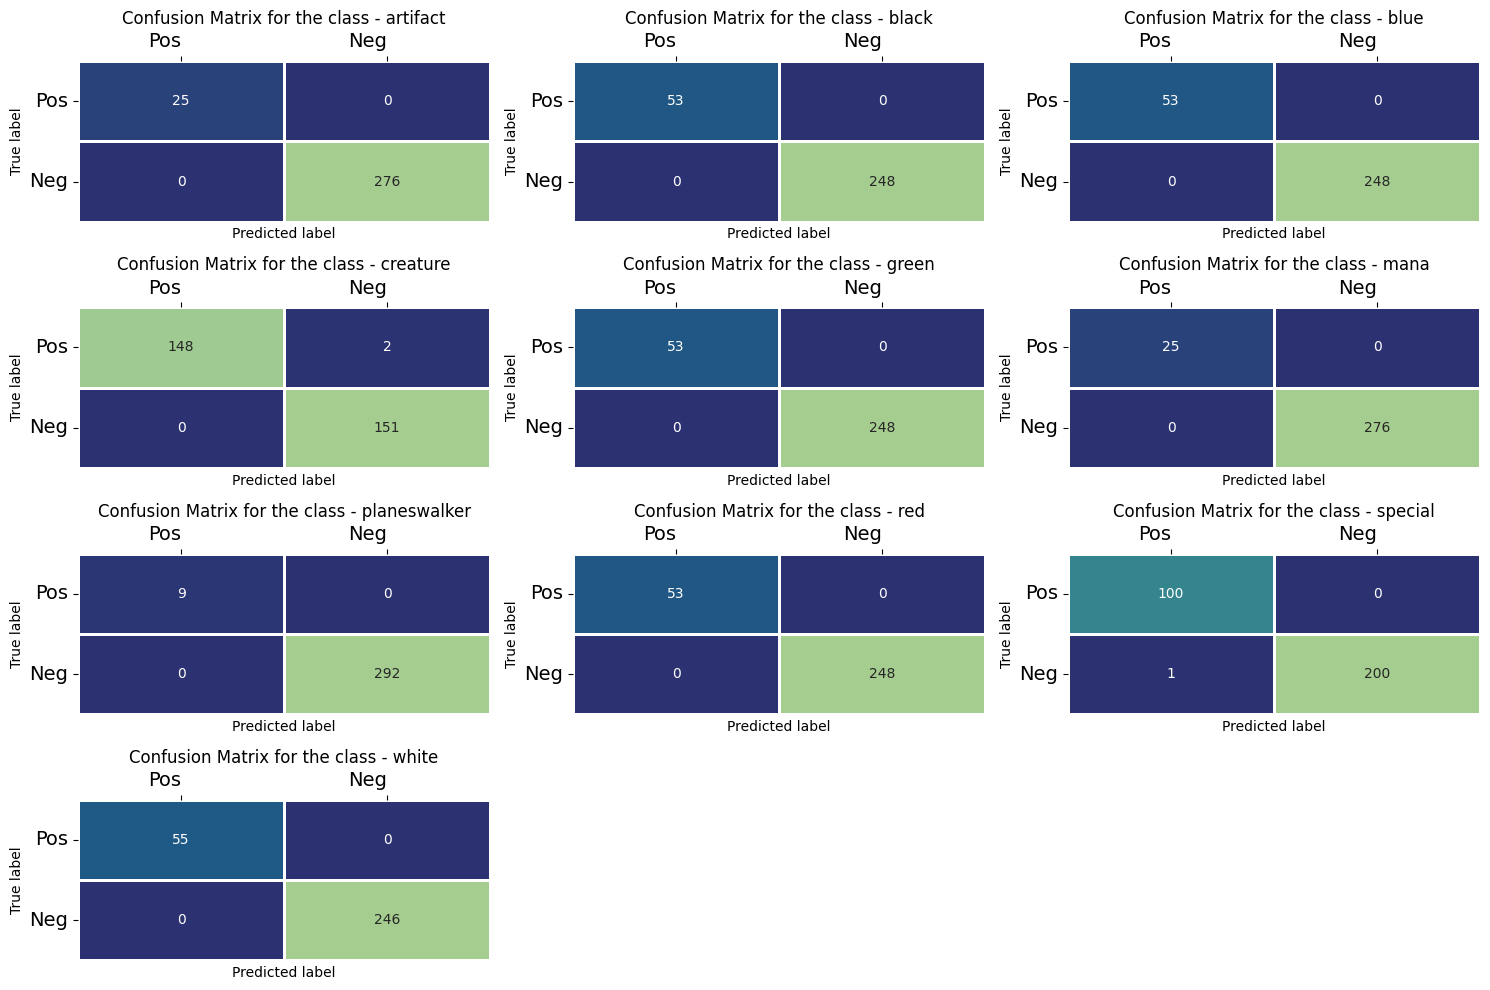

In [17]:
plot_multilabel_confusion_matrix(confusion_matrix,
                                 idx_to_class=test_data.idx_to_classes)

### 3.3 Visual

In [10]:
from src.visuals import plot_multilabel_predictions

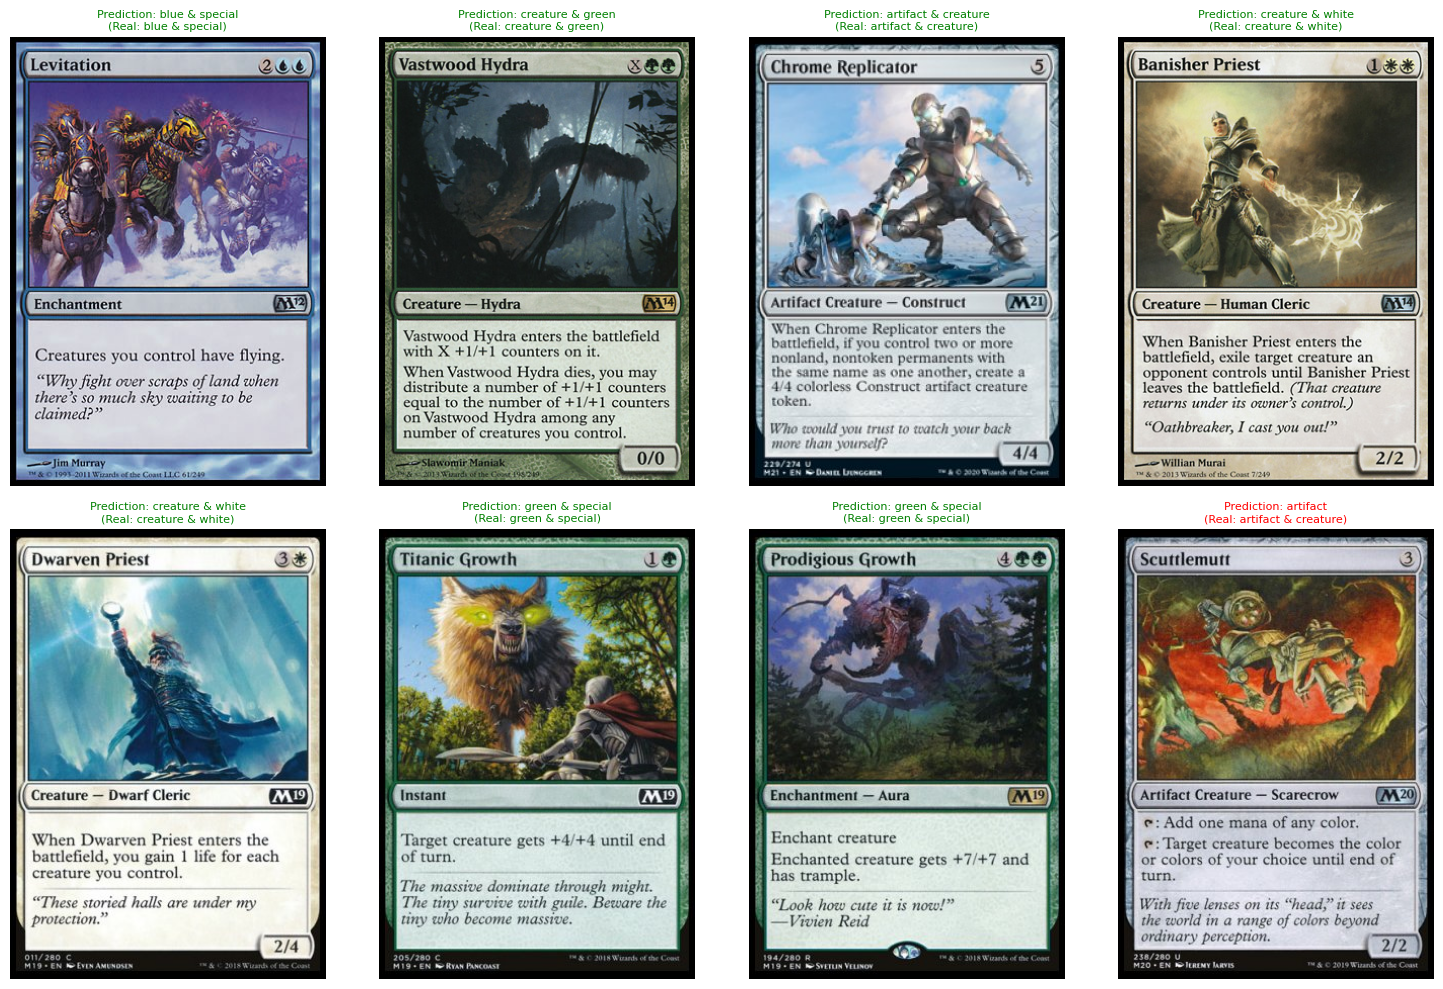

In [14]:
plot_multilabel_predictions(model, test_data)